# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to what subreddit it belongs to?_

Your method for acquiring the data will be scraping threads from at least two subreddits. 

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts which subreddit a given post belongs to.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [1]:
import requests
import time
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline

In [2]:
headers = {"User-Agent" : "Post Finder"}

In [3]:
URLmetalcore = "http://www.reddit.com/r/Metalcore/top.json"
URLmetal = "http://www.reddit.com/r/metal/top.json"

In [4]:
# thanks to zeke for showing me how to use params to access the top posts of all time instead of just the hot posts
param = {"t":"all"}
metalcore_res = requests.get(URLmetalcore, headers=headers, params=param)
metal_res = requests.get(URLmetal, headers=headers, params=param)

#### Pull Request Testing

In [5]:
print(metalcore_res.status_code)
print(metal_res.status_code)

200
200


In [6]:
metaljson = metal_res.json()
metalcorejson = metalcore_res.json()

In [7]:
for i in metalcorejson:
    if i == "'":
        i = '"'

In [8]:
# metalcorejson["data"]["children"][1]["data"]

In [9]:
corpus = []
for i in range(25):
    corpus.append(metalcorejson["data"]["children"][i]["data"]["selftext"])
    corpus.append(metalcorejson["data"]["children"][i]["data"]["title"])

In [10]:
corpus = [x for x in corpus if x != ""]

In [11]:
# corpus

#### Getting more results

By default, Reddit will give you the top 25 posts:

```python
print(len(data['data']['children']))
```

If you want more, you'll need to do two things:
1. Get the name of the last post: `data['data']['after']`
2. Use that name to hit the following url: `http://www.reddit.com/r/boardgames.json?after=THE_AFTER_FROM_STEP_1`
3. Create a loop to repeat steps 1 and 2 until you have a sufficient number of posts. 

*NOTE*: Reddit will limit the number of requests per second you're allowed to make. When you create your loop, be sure to add the following after each iteration.

```python
time.sleep(3) # sleeps 3 seconds before continuing```

This will throttle your loop and keep you within Reddit's guidelines. You'll need to import the `time` library for this to work!

In [12]:
# this is my real attempt!

In [13]:
# I dont think these variables are used
url_metalcore = "https://www.reddit.com/r/Metalcore/top.json"
url_metal = "https://www.reddit.com/r/Metal/top.json"

In [14]:
# confirming I know how to get to the next set of threads
# "https://www.reddit.com/r/Metal.json" + metal_res.json()["data"]["after"]

In [15]:
# creating the metal corpus
metal_list = []
metal_url = "https://www.reddit.com/r/Metal/top.json"
for i in range(1,40):
    temp_json = requests.get(metal_url, headers=headers, params=param).json()
    temp_list = []
    for j in range(1,25):
        temp_list.append(temp_json["data"]["children"][j]["data"]["selftext"])
        temp_list.append(temp_json["data"]["children"][j]["data"]["title"])
    metal_list.extend(temp_list)
    metal_url = "https://www.reddit.com/r/Metal/top.json?after=" + temp_json["data"]["after"]
    time.sleep(3)
        

KeyboardInterrupt: 

In [ ]:
# metalcore corpus
metalcore_list = []
metalcore_url = "https://www.reddit.com/r/Metalcore/top.json"
for i in range(1,40):
    temp_json2 = requests.get(metalcore_url, headers=headers, params=param).json()
    temp_list2 = []
    for j in range(1,25):
        temp_list2.append(temp_json2["data"]["children"][j]["data"]["selftext"])
        temp_list2.append(temp_json2["data"]["children"][j]["data"]["title"])
    metalcore_list.extend(temp_list2)
    metalcore_url = "https://www.reddit.com/r/Metalcore/top.json?after=" + temp_json2["data"]["after"]
    time.sleep(3)
    

In [ ]:
# removing posts with no self-text
metal_list = [x for x in metal_list if x != ""]
metalcore_list = [y for y in metalcore_list if y != ""]

In [ ]:
# checking data size after cleaning
metal_char_count = 0
for k in metal_list:
    metal_char_count += len(k)
    
metalcore_char_count = 0
for l in metalcore_list:
    metalcore_char_count += len(l)

In [ ]:
print(metal_char_count)
print(metalcore_char_count)

In [ ]:
# after pulling posts from the top, the metal dataset has gotten massively bigger

In [ ]:
metal = pd.DataFrame(metal_list, columns=["text"])
metalcore = pd.DataFrame(metalcore_list, columns=["text"])

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops or your computer crashes, you don't lose all your data.

In [ ]:
# # Export to csv
# metal.to_csv("./metal_csv")
# metalcore.to_csv("./metalcore_csv")

### Looking at the data

In [1]:
import requests
import time
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline

In [2]:
# dataframe --> csv --> dataframe for offline workin

In [3]:
metal_csv = "./metal_csv"
metalcore_csv = "./metalcore_csv"

metal = pd.read_csv(metal_csv)
metalcore = pd.read_csv(metalcore_csv)

In [4]:
metal.drop("Unnamed: 0", axis=1, inplace=True)
metalcore.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
metal.head()

,text
0,Eddie Trunk on Twitter: Sorry to report that I...
1,Chris Cornell (Soundgarden) has died at age 52
2,"Vinnie Paul, Legendary Drummer for Pantera &am..."
3,Teenage Metalhead gets Guitar for His Birthday...
4,Bruce Dickinson is cancer-free!


In [6]:
metalcore.head()

,text
0,Tear this place up!
1,Architects guitarist Tom Searle has lost his b...
2,Architects - Doomsday - NEW SONG
3,August Burns Red - Invisible Enemy (Official M...
4,"Congratulations, /r/Metalcore! You are subredd..."


### Assigning label

In [7]:
metalcore["is_metalcore"] = 1
metal["is_metalcore"] = 0

In [8]:
srdata = pd.merge(metalcore, metal, how="outer")

In [9]:
srdata.head(3)

,text,is_metalcore
0,Tear this place up!,1
1,Architects guitarist Tom Searle has lost his b...,1
2,Architects - Doomsday - NEW SONG,1


In [10]:
srdata.tail(3)

,text,is_metalcore
2242,Venom- Teacher’s Pet [FFO: Approaching Finals],0
2243,Pallbearer to release third album 'Heartless' ...,0
2244,CARCASS - No Love Lost,0


In [11]:
# checking balance
srdata.is_metalcore.value_counts()
# everything is a-okay

0    1139
1    1106
Name: is_metalcore, dtype: int64

In [12]:
# now I have a dataframe with all entries, text as my feature, and is_metalcore as the target 

## NLP

#### Use `CountVectorizer` or `TfidfVectorizer` from scikit-learn to create features from the thread titles and descriptions (NOTE: Not all threads have a description)
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [13]:
# adding custom stop words "metal" and "metalcore" because theyre the subreddit names
from sklearn.feature_extraction import stop_words
custom_stops = list(stop_words.ENGLISH_STOP_WORDS)
# custom_stops.append("metal")
# custom_stops.append("metalcore")
# custom_stops.append("core")
# custom_stops.append("shreddit")

# based on the new prompt I decided it was acceptable to include the subreddit names and nicknames in the model
# without custom stop words, the models are ~5% less accurate

#### CountVectorizer first

In [14]:
cv = CountVectorizer(stop_words=custom_stops)

In [15]:
features_df = srdata["text"]

In [16]:
# splitting (will use the same split for each model)
X = features_df
y = srdata["is_metalcore"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6, stratify=y)

In [18]:
Xcvt_train = cv.fit_transform(X_train)
Xcvt_test = cv.transform(X_test)

In [19]:
Xcvt_train_features = pd.DataFrame(Xcvt_train.todense(),
                   columns=cv.get_feature_names())

In [20]:
# checking out the features
Xcvt_train_features.head()

,00,000,00e6rtjh2ro,00pm,00s,01,02,027yeq9uueu,03,04,...,криницях,кров,кровоизлияние,наших,сталі,コンプレックス,悪魔が来たりてヘヴィメタる,有角神舞踏,根腐劣屑,聖飢魔ii
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
Xcvt_train_features["00"].sum()

7

In [22]:
xcvt_summed = pd.DataFrame(Xcvt_train_features.sum())
xcvt_summed.nlargest(n=20, columns=0)

,0
com,1472
https,1275
www,1221
youtube,1049
watch,1008
metal,1002
album,609
band,457
bands,443
death,433


#### CV classifying

In [23]:
# setting up multinomialNB

mnb_cv = MultinomialNB()
mnb_cv.fit(Xcvt_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
cross_val_score(mnb_cv, Xcvt_train, y_train).mean()

0.8157973277739868

In [25]:
# predicting and assessing

mnbcv_preds = mnb_cv.predict(Xcvt_test)
tn_mnbcv, fp_mnbcv, fn_mnbcv, tp_mnbcv = confusion_matrix(y_test, mnbcv_preds).ravel()

print("MNB CV Accuracy =", ((tn_mnbcv+tp_mnbcv)/(fp_mnbcv+fn_mnbcv+tn_mnbcv+tp_mnbcv)))
# not terrible
tp_mnbcv/(tp_mnbcv+fp_mnbcv)

MNB CV Accuracy = 0.8540925266903915


0.8327645051194539

#### LogReg classifying

In [26]:
# setting up logistic

lr_cv = LogisticRegression()
lr_cv.fit(Xcvt_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
cross_val_score(lr_cv, Xcvt_train, y_train).mean()

0.898998160679132

In [28]:
lrcv_preds = lr_cv.predict(Xcvt_test)
lrcv_tn, lrcv_fp, lrcv_fn, lrcv_tp = confusion_matrix(y_test, lrcv_preds).ravel()

print("LogReg CV Accuracy =", ((lrcv_tn+lrcv_tp)/(lrcv_fp+lrcv_fn+lrcv_tn+lrcv_tp)))
# oooeee

lrcv_tp/(lrcv_tp+lrcv_fp)

LogReg CV Accuracy = 0.9074733096085409


0.915129151291513

### Tfidf Vect next

In [29]:
tf = TfidfVectorizer(stop_words=custom_stops)

In [30]:
Xtft_train = tf.fit_transform(X_train)
Xtft_test = tf.transform(X_test)

In [31]:
Xtft_train_features = pd.DataFrame(Xtft_train.todense(),
                   columns=tf.get_feature_names())

In [32]:
# checking features
Xtft_train_features.head()
# cool

,00,000,00e6rtjh2ro,00pm,00s,01,02,027yeq9uueu,03,04,...,криницях,кров,кровоизлияние,наших,сталі,コンプレックス,悪魔が来たりてヘヴィメタる,有角神舞踏,根腐劣屑,聖飢魔ii
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
tfidf_summed = pd.DataFrame(Xtft_train_features.sum())
tfidf_summed.nlargest(n=20, columns=0)

,0
new,42.235122
metal,37.261999
album,36.292722
video,27.052090
music,26.338030
official,26.072965
com,25.169610
https,20.375085
band,18.324724
tour,17.717661


#### MNB classifying

In [34]:
mnb_tf = MultinomialNB()

In [35]:
mnb_tf.fit(Xtft_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
cross_val_score(mnb_tf, Xtft_train, y_train).mean()

0.8841235820328347

In [37]:
mnbtf_preds = mnb_tf.predict(Xtft_test)
mnbtf_tn, mnbtf_fp, mnbtf_fn, mnbtf_tp = confusion_matrix(y_test, mnbtf_preds).ravel()
print("MNB Tfidf Accuracy = ", ((mnbtf_tn+mnbtf_tp)/(mnbtf_fp+mnbtf_fn+mnbtf_tn+mnbtf_tp)))
mnbtf_tp/(mnbtf_tp+mnbtf_fp)
# it's exactly the same as the logreg model score

MNB Tfidf Accuracy =  0.8985765124555161


0.9198473282442748

#### LogReg & tfidf

In [38]:
lr_tf = LogisticRegression()

In [39]:
lr_tf.fit(Xtft_train, y_train)
cross_val_score(lr_tf, Xtft_train, y_train).mean()

0.882945811776668

In [40]:
lrtf_preds = lr_tf.predict(Xtft_test)
lrtf_tn, lrtf_fp, lrtf_fn, lrtf_tp = confusion_matrix(y_test, lrtf_preds).ravel()
print("LogReg Tfidf Accuracy = ", ((lrtf_tn+lrtf_tp)/(lrtf_fp+mnbtf_fn+lrtf_tn+mnbtf_tp)))
lrtf_tp/(lrtf_tp+lrtf_fp)

LogReg Tfidf Accuracy =  0.891459074733096


0.9186046511627907

### Examining Coefficients

In [41]:
lr_tf_coefs = lr_tf.coef_
lr_tf_df = pd.DataFrame((lr_tf_coefs))
lr_tf_df = lr_tf_df.transpose()
lr_tf_df.set_index(Xtft_train_features.columns, inplace=True)

In [42]:
lr_tf_df.sort_values(by=0, ascending=False, inplace=True)

In [43]:
coef_pos = lr_tf_df.iloc[0:10]

In [44]:
lr_tf_df.sort_values(by=0, ascending=True, inplace=True)

In [45]:
coef_neg = lr_tf_df.iloc[0:10]

In [46]:
coef_map = {0:"coefficient"}
coef_pos.rename(mapper=coef_map, inplace=True, axis=1)
coef_neg.rename(mapper=coef_map, inplace=True, axis=1)

/Users/brianconnor/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [47]:
coef_pos.index.rename("Word", inplace=True)

In [48]:
coef_pos.rename({"coefficient":"Coefficient"}, axis=1, inplace=True)

/Users/brianconnor/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [49]:
coef_neg.index.rename("Word", inplace=True)
coef_neg.rename({"coefficient":"Coefficient"}, axis=1, inplace=True)

/Users/brianconnor/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [50]:
coef_neg

,Coefficient
Word,
metal,-4.309525
slayer,-2.310297
black,-1.995014
mastodon,-1.971248
death,-1.795927
shreddit,-1.625292
maiden,-1.612572
gt,-1.591266
band,-1.502219


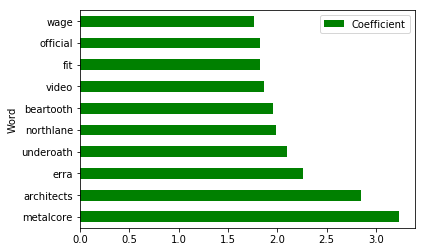

In [51]:
coef_pos.plot(kind="barh", color="green")

Text(0.5,1,'Metalcore Coefficients')

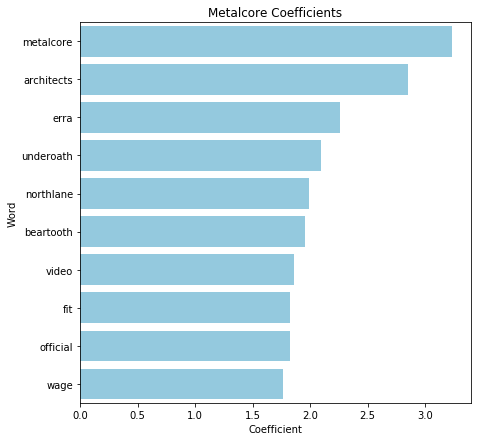

In [52]:
fig, ax = plt.subplots(figsize=(7,7))
sns.barplot(x=coef_pos["Coefficient"], y=coef_pos.index, orient="h", color="skyblue")
ax.set_title("Metalcore Coefficients")

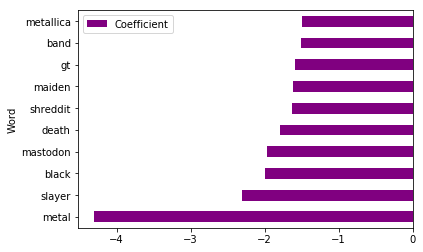

In [53]:
coef_neg.plot(kind="barh", color="purple")

Text(0.5,1,'Metal Coefficients')

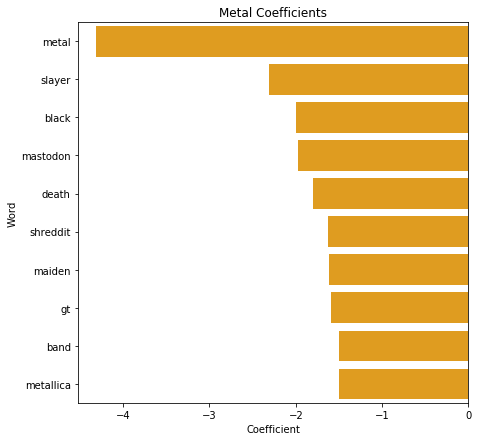

In [54]:
fig, ax = plt.subplots(figsize=(7,7))
sns.barplot(x=coef_neg["Coefficient"], y=coef_neg.index, orient="h", color="orange")
ax.set_title("Metal Coefficients")

In [66]:
lr_tf_df.sort_values(by=0, ascending=False, inplace=True)

In [67]:
lr_tf_df.head(50)

,0
metalcore,3.231728
architects,2.851161
erra,2.263458
underoath,2.094175
northlane,1.985886
beartooth,1.958721
video,1.861770
fit,1.826779
official,1.822649
wage,1.767218


## Predicting subreddit using Random Forests + Another Classifier

In [55]:
rf = RandomForestClassifier()

#### We want to predict a binary variable - class `0` for one of your subreddits and `1` for the other.

In [56]:
cross_val_score(rf, Xtft_train, y_train).mean()

0.8229401584854799

In [57]:
rf.fit(Xtft_train, y_train)
rf.score(Xtft_test, y_test)

0.8362989323843416

#### Thought experiment: What is the baseline accuracy for this model?

In [58]:
# 50%?

#### Create a `RandomForestClassifier` model to predict which subreddit a given post belongs to.

In [59]:
rf_preds = rf.predict(Xtft_test)
rf_tn, rf_fp, rf_fn, rf_tp = confusion_matrix(y_test, rf_preds).ravel()
print("Random Forest Accuracy = ", ((rf_tn+rf_tp)/(rf_fn+rf_fp+rf_tn+rf_tp)))

Random Forest Accuracy =  0.8362989323843416


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 
- **Bonus**: Use `GridSearchCV` with `Pipeline` to optimize your `CountVectorizer`/`TfidfVectorizer` and classification model.

#### Repeat the model-building process using a different classifier (e.g. `MultinomialNB`, `LogisticRegression`, etc)

In [60]:
## already did it! 

# Executive Summary
---
Put your executive summary in a Markdown cell below.